In [2]:
from numpy import *
from qiskit import *
from math import *
from numpy import *
import networkx as nx
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.circuit.library import QFT

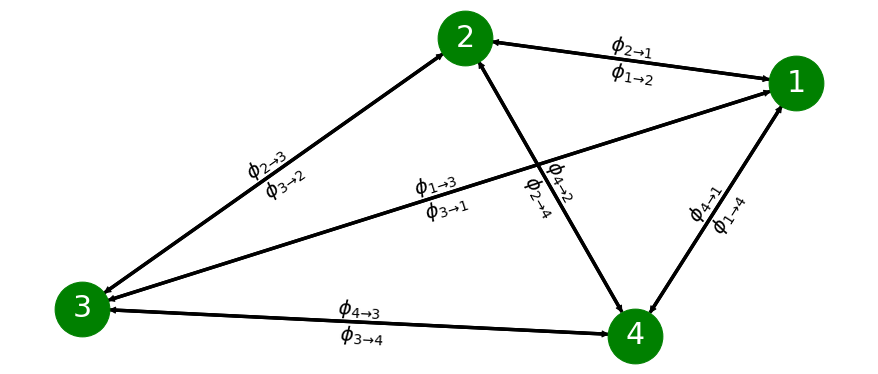

In [3]:
##############TSP-GRAPH################
G = nx.DiGraph(directed=True)

G.add_edge(1, 2)
G.add_edge(1, 3)
G.add_edge(1, 4)

G.add_edge(2, 1)
G.add_edge(2, 3)
G.add_edge(2, 4)

G.add_edge(3, 1)
G.add_edge(3, 2)
G.add_edge(3, 4)

G.add_edge(4, 1)
G.add_edge(4, 2)
G.add_edge(4, 3)


pos = {1: [1.51, 0.25],
      2: [0.81, 0.3],
      3: [0, 0],
      4: [1.17, -0.03]}
#These positions were found by finding a coordinate grid with Memphis at (0,0), then
#noting that pi/2 is about 1.5, I divided the greatest x coordinate, 347, by 1.5 to get
#230. I then divided all other coordinates by 230 as well so that it would be to scale
#but still possible to graph on the diagram and not too difficult to use the QPE algorithm on

edge_labels = {(1, 2): '$\\phi_{2\\to 1}$\n $\\phi_{1\\to 2}$',
              (1, 3): '$\\phi_{1\\to 3}$\n $\\phi_{3\\to 1}$',
              (1, 4): '$\\phi_{4\\to 1}$\n $\\phi_{1\\to 4}$',
              (2, 3): '$\\phi_{2\\to 3}$\n $\\phi_{3\\to 2}$',
              (2, 4): '$\\phi_{4\\to 2}$\n $\\phi_{2\\to 4}$',
              (3, 4): '$\\phi_{4\\to 3}$\n $\\phi_{3\\to 4}$'
              }

fig = plt.figure(1, figsize=(12, 5)) 
nx.draw(G, with_labels=True, node_color='green', pos=pos, node_size=3000, arrowsize=12, arrowstyle='simple', font_size=30, font_color = 'white')

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=20, bbox=dict(alpha=0))
 
plt.show()

In [12]:
def controlled_unitary(qc, qubits: list, phases: list): # x,y,z = Specific Qubit; a,b,c,d = Phases
    qc.cp(phases[2]-phases[0], qubits[0], qubits[1]) # controlled-U1(c-a)
    qc.p(phases[0], qubits[0]) # U1(a)
    qc.cp(phases[1]-phases[0], qubits[0], qubits[2]) # controlled-U1(b-a)
    
    # controlled controlled U1(d-c+a-b)
    qc.cp((phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[1], qubits[2])
    qc.cx(qubits[0], qubits[1])
    qc.cp(-(phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[1], qubits[2])
    qc.cx(qubits[0], qubits[1])
    qc.cp((phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[0], qubits[2])

def U(times, qc, unit, eigen, phases: list): # a,b,c = phases for U1; d,e,f = phases for U2; g,h,i = phases for U3; j,k,l = phases for U4; m_list=[m, n, o, p, q, r, s, t, u, a, b, c, d, e, f, g, h, i, j, k, l]
    controlled_unitary(qc, [unit[0]]+eigen[0:2], [0]+phases[0:3])
    controlled_unitary(qc, [unit[0]]+eigen[2:4], [phases[3]]+[0]+phases[4:6])
    controlled_unitary(qc, [unit[0]]+eigen[4:6], phases[6:8]+[0]+[phases[8]])
    controlled_unitary(qc, [unit[0]]+eigen[6:8], phases[9:12]+[0])
    
def final_U(times, eigen, phases: list):
    unit = QuantumRegister(1, 'unit')
    qc = QuantumCircuit(unit, eigen)
    for _ in range(2**times):
        U(times, qc, unit, eigen, phases)
    return qc.to_gate(label='U'+'_'+(str(2**times)))

# Storing the eigenvalues in a list
eigen_values = ["11000110", "10000111", "10001101", "01001110", "11001001", "01001011"]
#index 0 is 1-2-3-4
#index 1 is 1-2-4-3
#index 2 is 1-4-2-3
#index 3 is 1-4-3-2
#index 4 is 1-3-2-4
#index 5 is 1-3-4-2

def which_eigen(index):
    if index == 0:
        return "1-2-3-4"
    elif index == 1:
        return "1-2-4-3"
    elif index == 2:
        return "1-4-2-3"
    elif index == 3:
        return "1-4-3-2"
    elif index == 4:
        return "1-3-2-4"
    else:
        return "1-3-4-2"

# Function to place appropriate corresponding gate according to eigenstates
def eigenstates(qc, eigen_list, index):
    for i in range(0, len(eigen_list)):
        if eigen_values[index][i] == '1':
            qc.x(eigen_list[i])
        if eigen_values[index][i] == '0':
            pass
    qc.barrier()
    print("Chosen Eigen value is:", eigen_values[index], "which is", which_eigen(index))
    return qc

#Initializing the values for the array
x = pi/(2*349.44)
print(x)
phases = [(160.48)*x, (349.44)*x, (100.69)*x, (160.48)*x, (196.87)*x, (113.23)*x, (349.44)*x, (196.87)*x, (268.24)*x, (100.69)*x, (113.23)*x, (268.24)*x]
print(phases)

0.004495181796001879
[0.7213867746223815, 1.5707963267948966, 0.4526198550394292, 0.7213867746223815, 0.8849664401788899, 0.5089894347612928, 1.5707963267948966, 0.8849664401788899, 1.205787564959544, 0.4526198550394292, 0.5089894347612928, 1.205787564959544]


Chosen Eigen value is: 11000110 which is 1-2-3-4


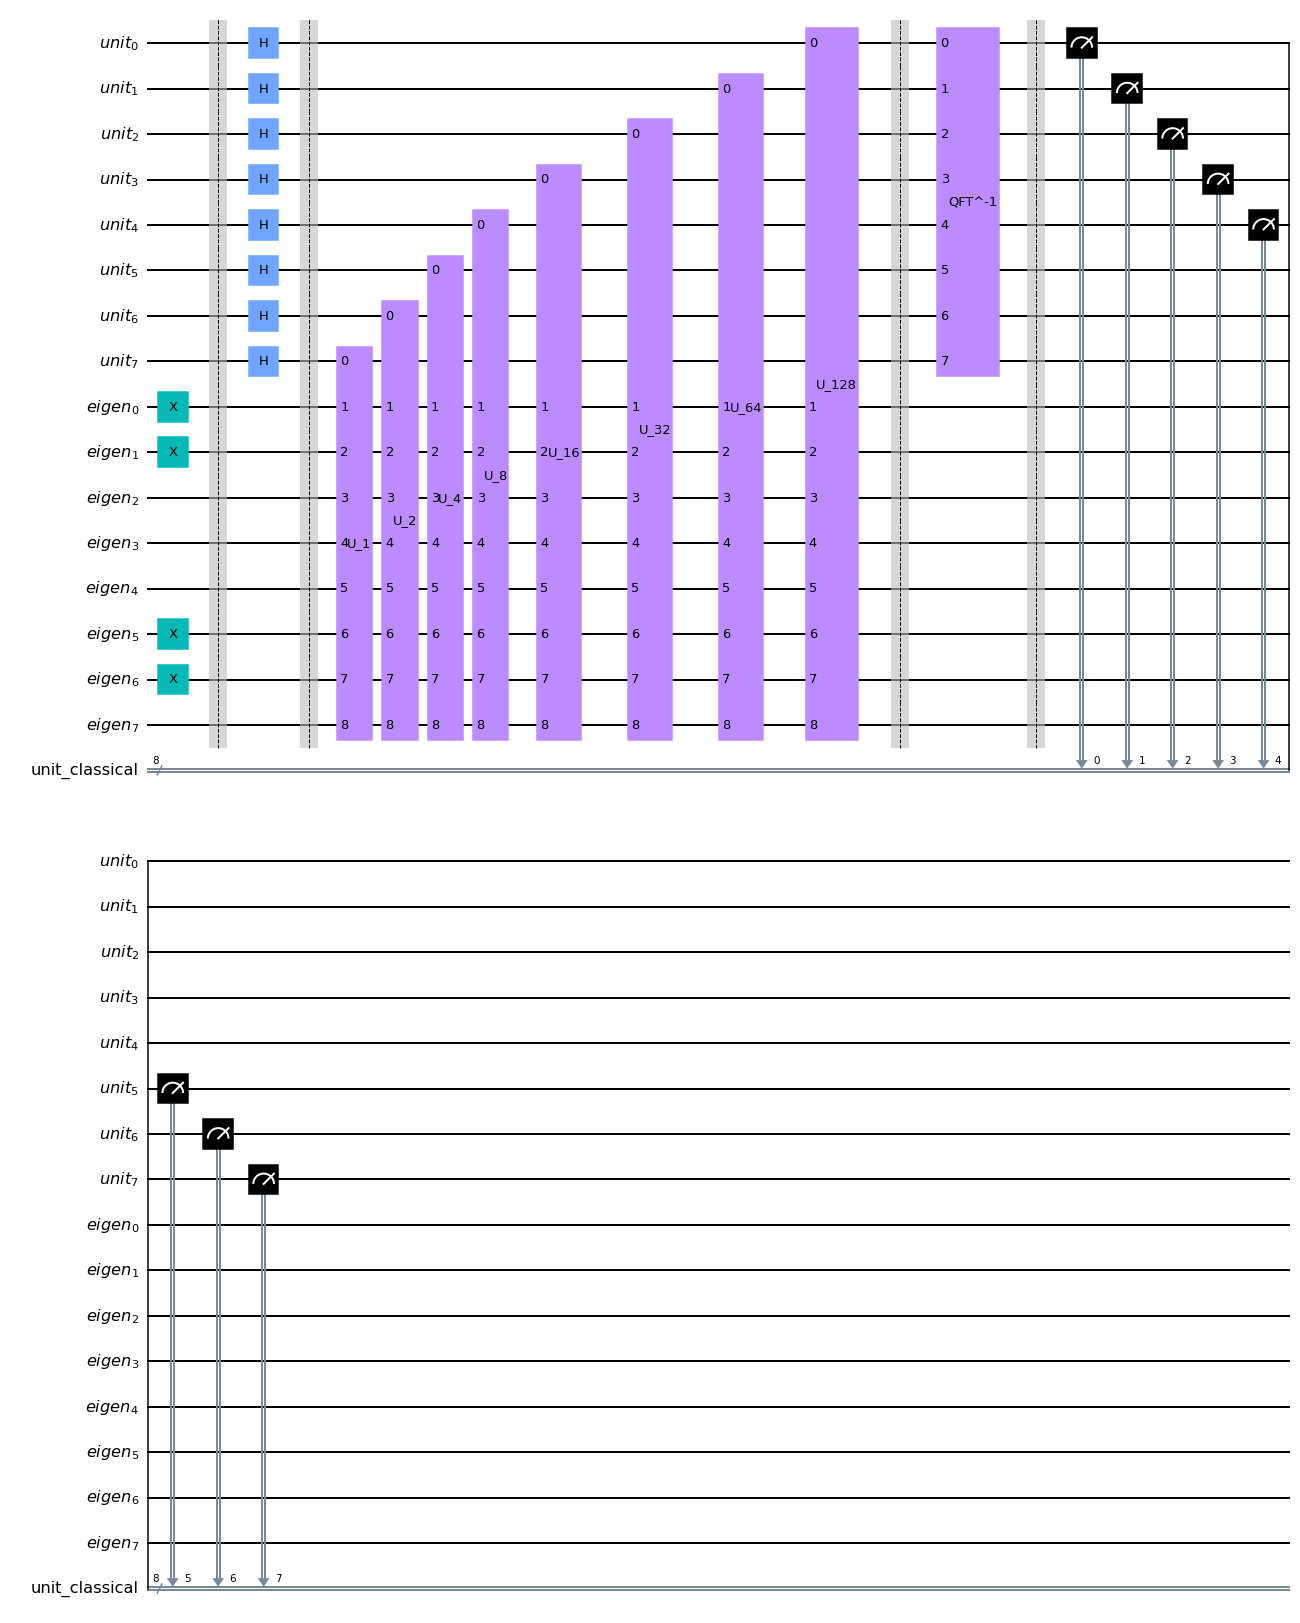

In [5]:
##############INDEX 0##########################
# Creating the 14 qubit circuit, 6 are for the qft and the rest are for the eigenvectors/QPE
unit = QuantumRegister(8, 'unit')
eigen = QuantumRegister(8, 'eigen')
unit_classical = ClassicalRegister(8, 'unit_classical')
qc = QuantumCircuit(unit, eigen, unit_classical)
#

# Setting one eigenstate, puts not gates into circuit  
eigenstates(qc, eigen, 0)
#

# Hadamard on the 'unit' qubits
qc.h(unit[:])
qc.barrier()
#

# Controlled Unitary  
for i in range(0, 8):
    qc.append(final_U(i, eigen, phases), [unit[7-i]] + eigen[:])
#

# Inverse QFT 
qc.barrier()
qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=True, do_swaps=False, name='QFT^-1')
qc.append(qft, qc.qubits[:len(unit)])
qc.barrier()
#

# Measure
qc.measure(unit, unit_classical)
#

# Draw
qc.draw('mpl')



Chosen Eigen value is: 10000111 which is 1-2-4-3


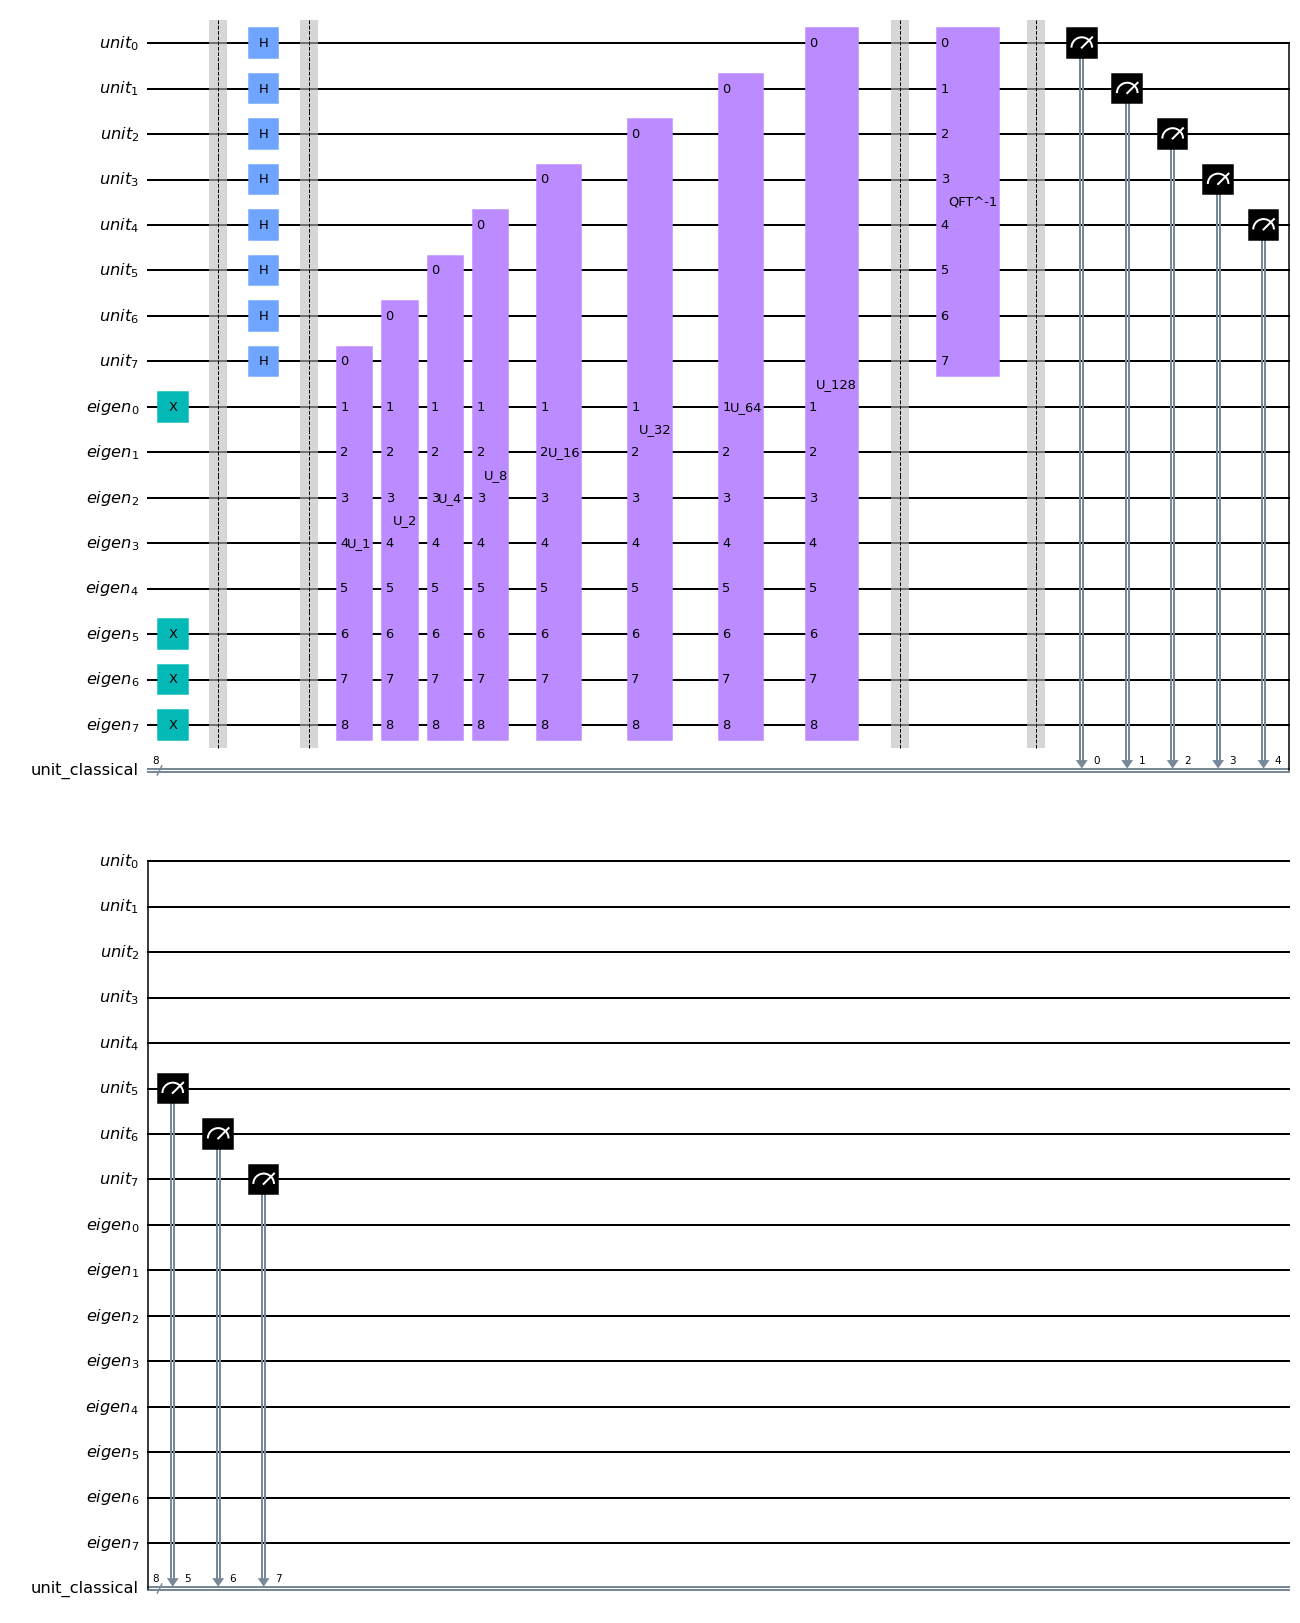

In [6]:
##############INDEX 1##########################
# Creating the 14 qubit circuit, 6 are for the qft and the rest are for the eigenvectors/QPE
unit = QuantumRegister(8, 'unit')
eigen = QuantumRegister(8, 'eigen')
unit_classical = ClassicalRegister(8, 'unit_classical')
qc1 = QuantumCircuit(unit, eigen, unit_classical)
#

# Setting one eigenstate, puts not gates into circuit  
eigenstates(qc1, eigen, 1)
#

# Hadamard on the 'unit' qubits
qc1.h(unit[:])
qc1.barrier()
#

# Controlled Unitary  
for i in range(0, 8):
    qc1.append(final_U(i, eigen, phases), [unit[7-i]] + eigen[:])
#

# Inverse QFT 
qc1.barrier()
qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=True, do_swaps=False, name='QFT^-1')
qc1.append(qft, qc1.qubits[:len(unit)])
qc1.barrier()
#

# Measure
qc1.measure(unit, unit_classical)
#

# Draw
qc1.draw('mpl')

Chosen Eigen value is: 10001101 which is 1-4-2-3


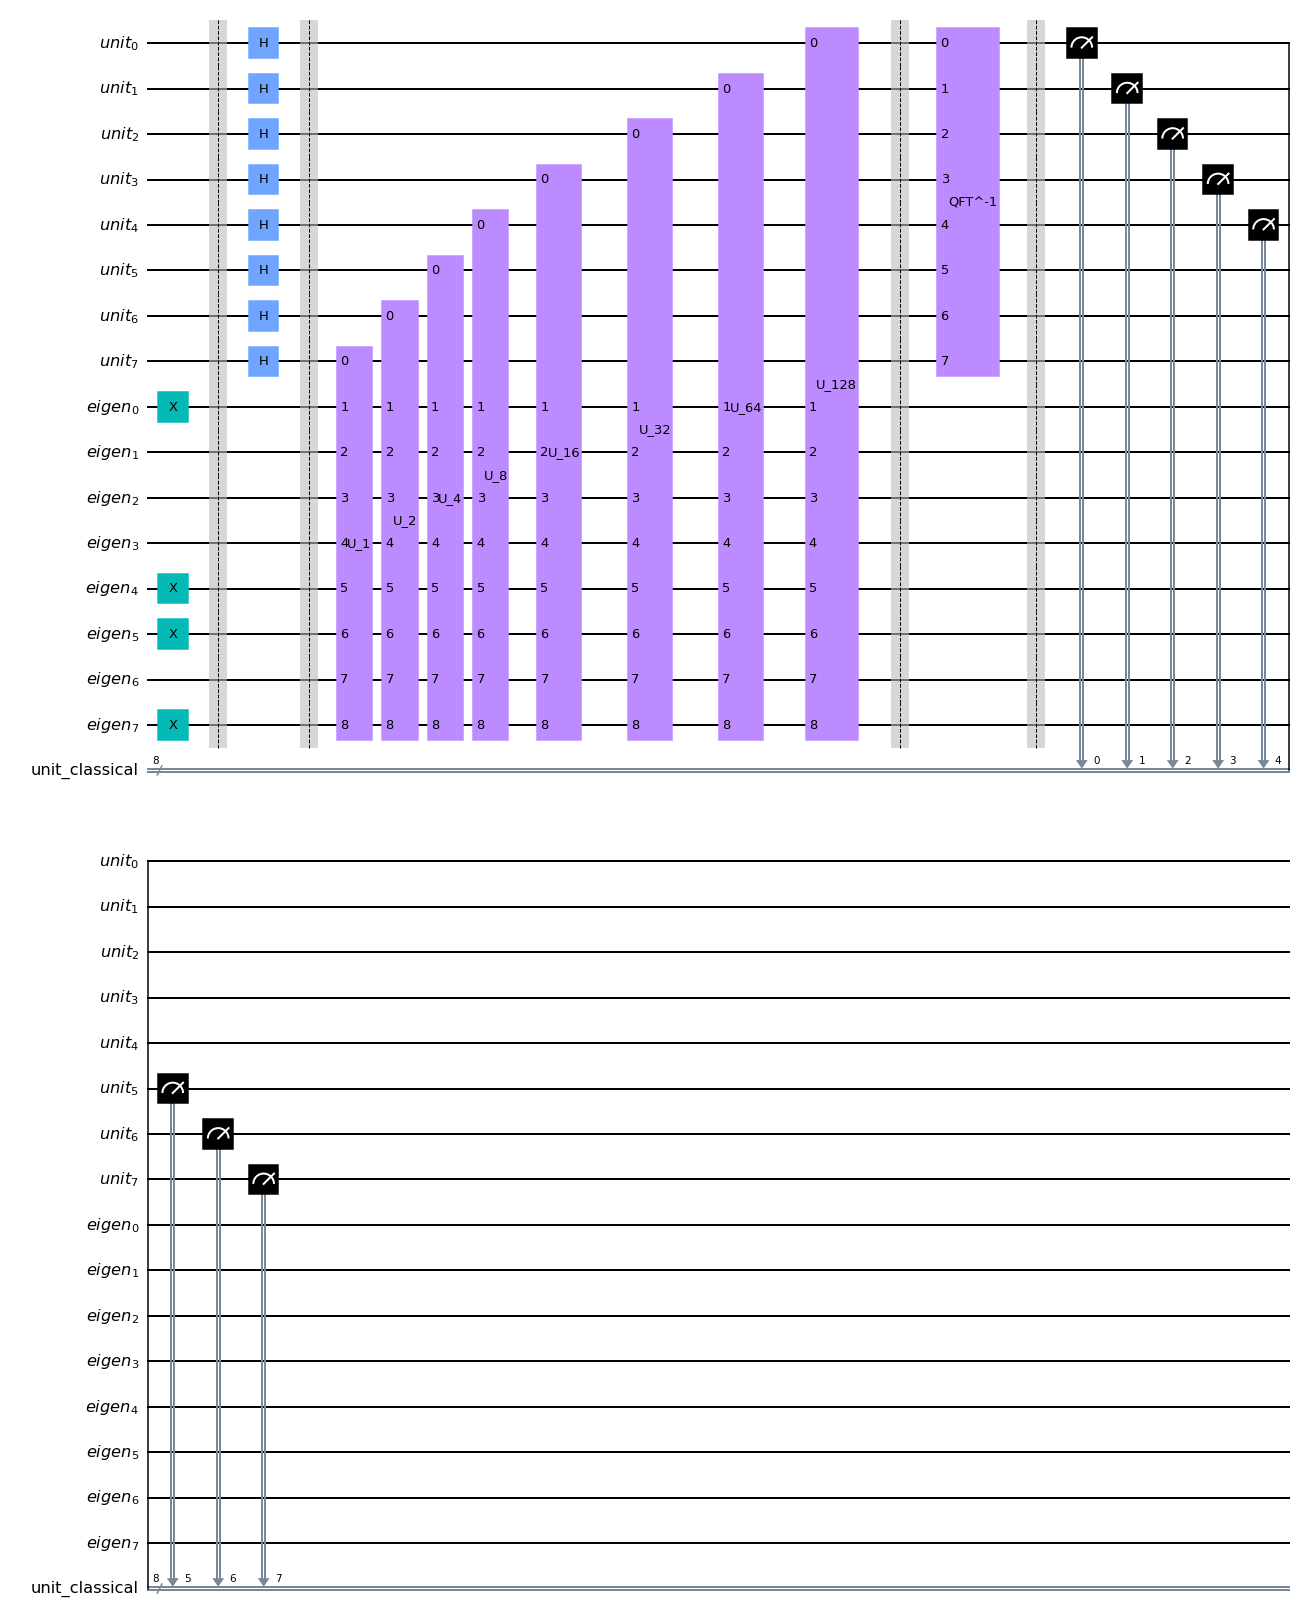

In [7]:
##############INDEX 2##########################
# Creating the 14 qubit circuit, 6 are for the qft and the rest are for the eigenvectors/QPE
unit = QuantumRegister(8, 'unit')
eigen = QuantumRegister(8, 'eigen')
unit_classical = ClassicalRegister(8, 'unit_classical')
qc2 = QuantumCircuit(unit, eigen, unit_classical)
#

# Setting one eigenstate, puts not gates into circuit  
eigenstates(qc2, eigen, 2)
#

# Hadamard on the 'unit' qubits
qc2.h(unit[:])
qc2.barrier()
#

# Controlled Unitary  
for i in range(0, 8):
    qc2.append(final_U(i, eigen, phases), [unit[7-i]] + eigen[:])
#

# Inverse QFT 
qc2.barrier()
qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=True, do_swaps=False, name='QFT^-1')
qc2.append(qft, qc2.qubits[:len(unit)])
qc2.barrier()
#

# Measure
qc2.measure(unit, unit_classical)
#

# Draw
qc2.draw('mpl')

Chosen Eigen value is: 01001110 which is 1-4-3-2


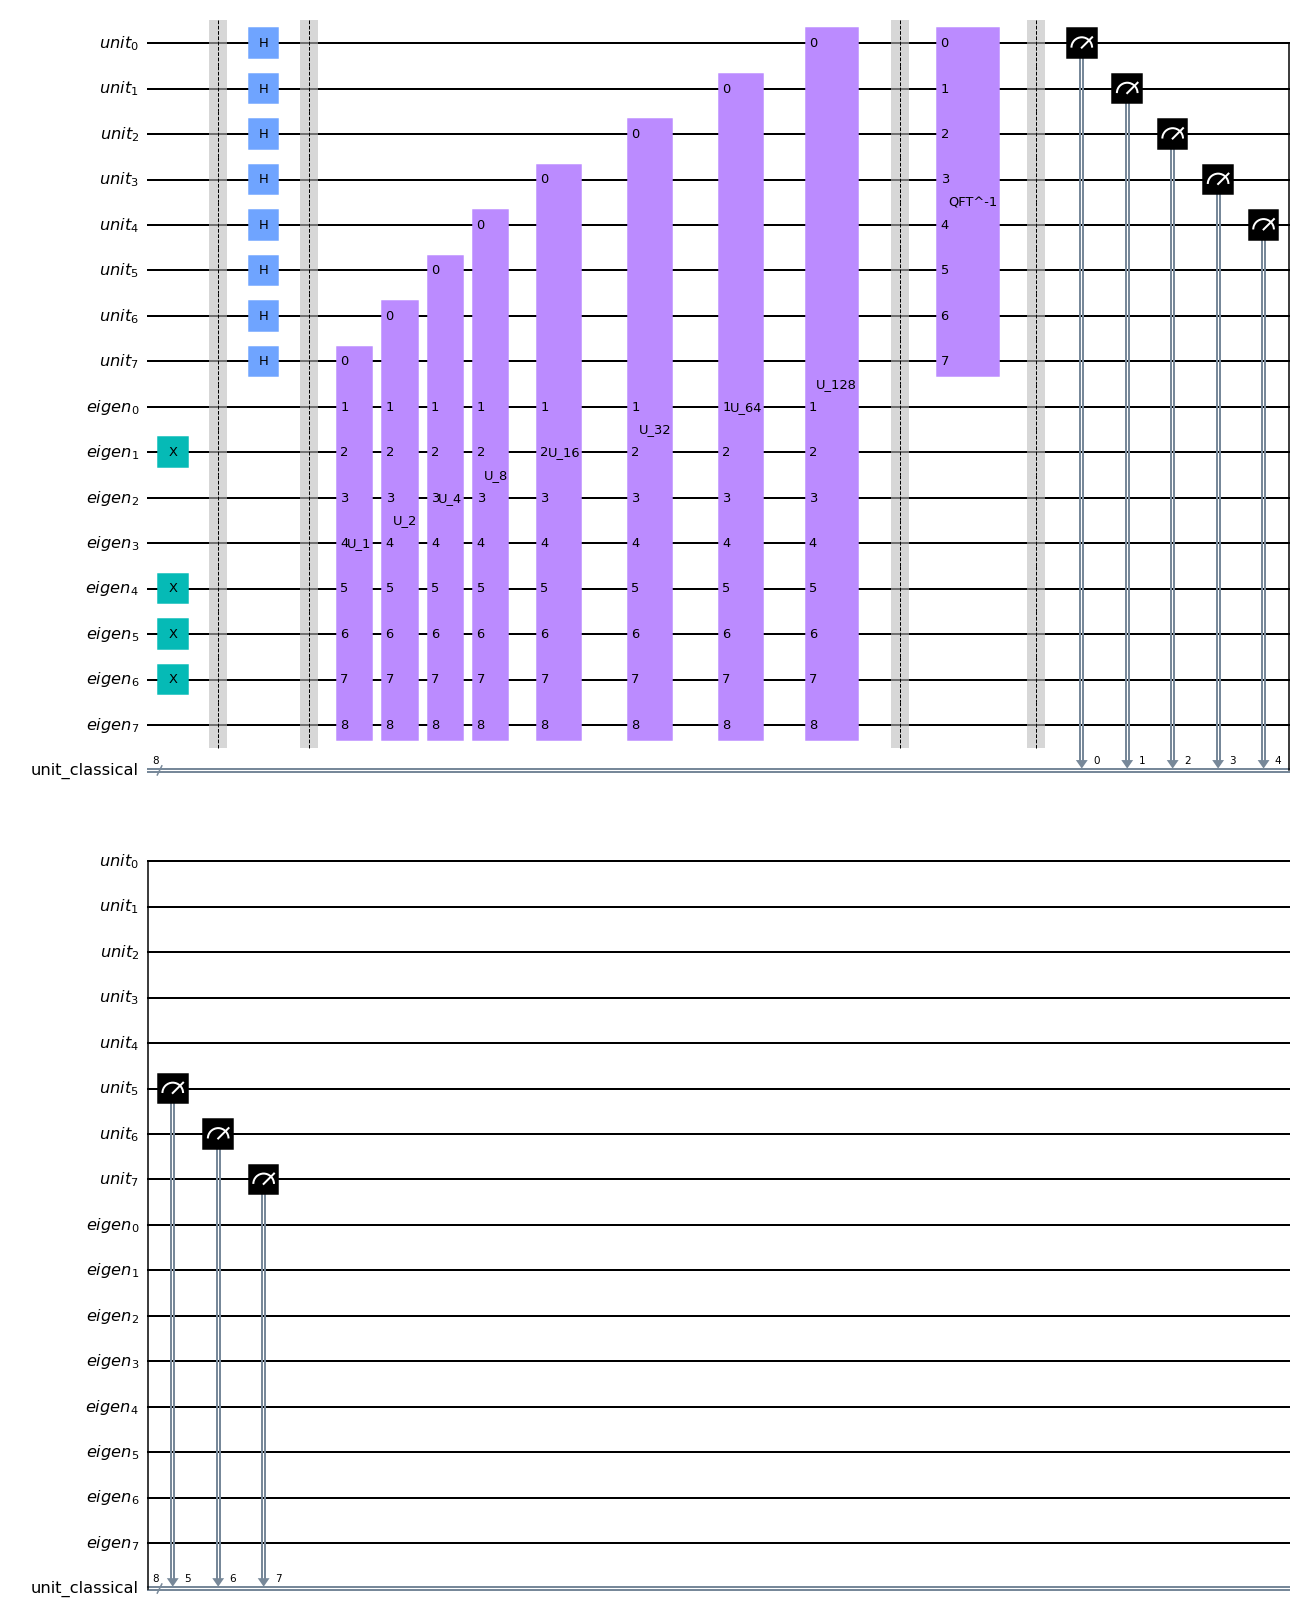

In [8]:
##############INDEX 3##########################
# Creating the 14 qubit circuit, 6 are for the qft and the rest are for the eigenvectors/QPE
unit = QuantumRegister(8, 'unit')
eigen = QuantumRegister(8, 'eigen')
unit_classical = ClassicalRegister(8, 'unit_classical')
qc3 = QuantumCircuit(unit, eigen, unit_classical)
#

# Setting one eigenstate, puts not gates into circuit  
eigenstates(qc3, eigen, 3)
#

# Hadamard on the 'unit' qubits
qc3.h(unit[:])
qc3.barrier()
#

# Controlled Unitary  
for i in range(0, 8):
    qc3.append(final_U(i, eigen, phases), [unit[7-i]] + eigen[:])
#

# Inverse QFT 
qc3.barrier()
qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=True, do_swaps=False, name='QFT^-1')
qc3.append(qft, qc3.qubits[:len(unit)])
qc3.barrier()
#

# Measure
qc3.measure(unit, unit_classical)
#

# Draw
qc3.draw('mpl')


Chosen Eigen value is: 11001001 which is 1-3-2-4


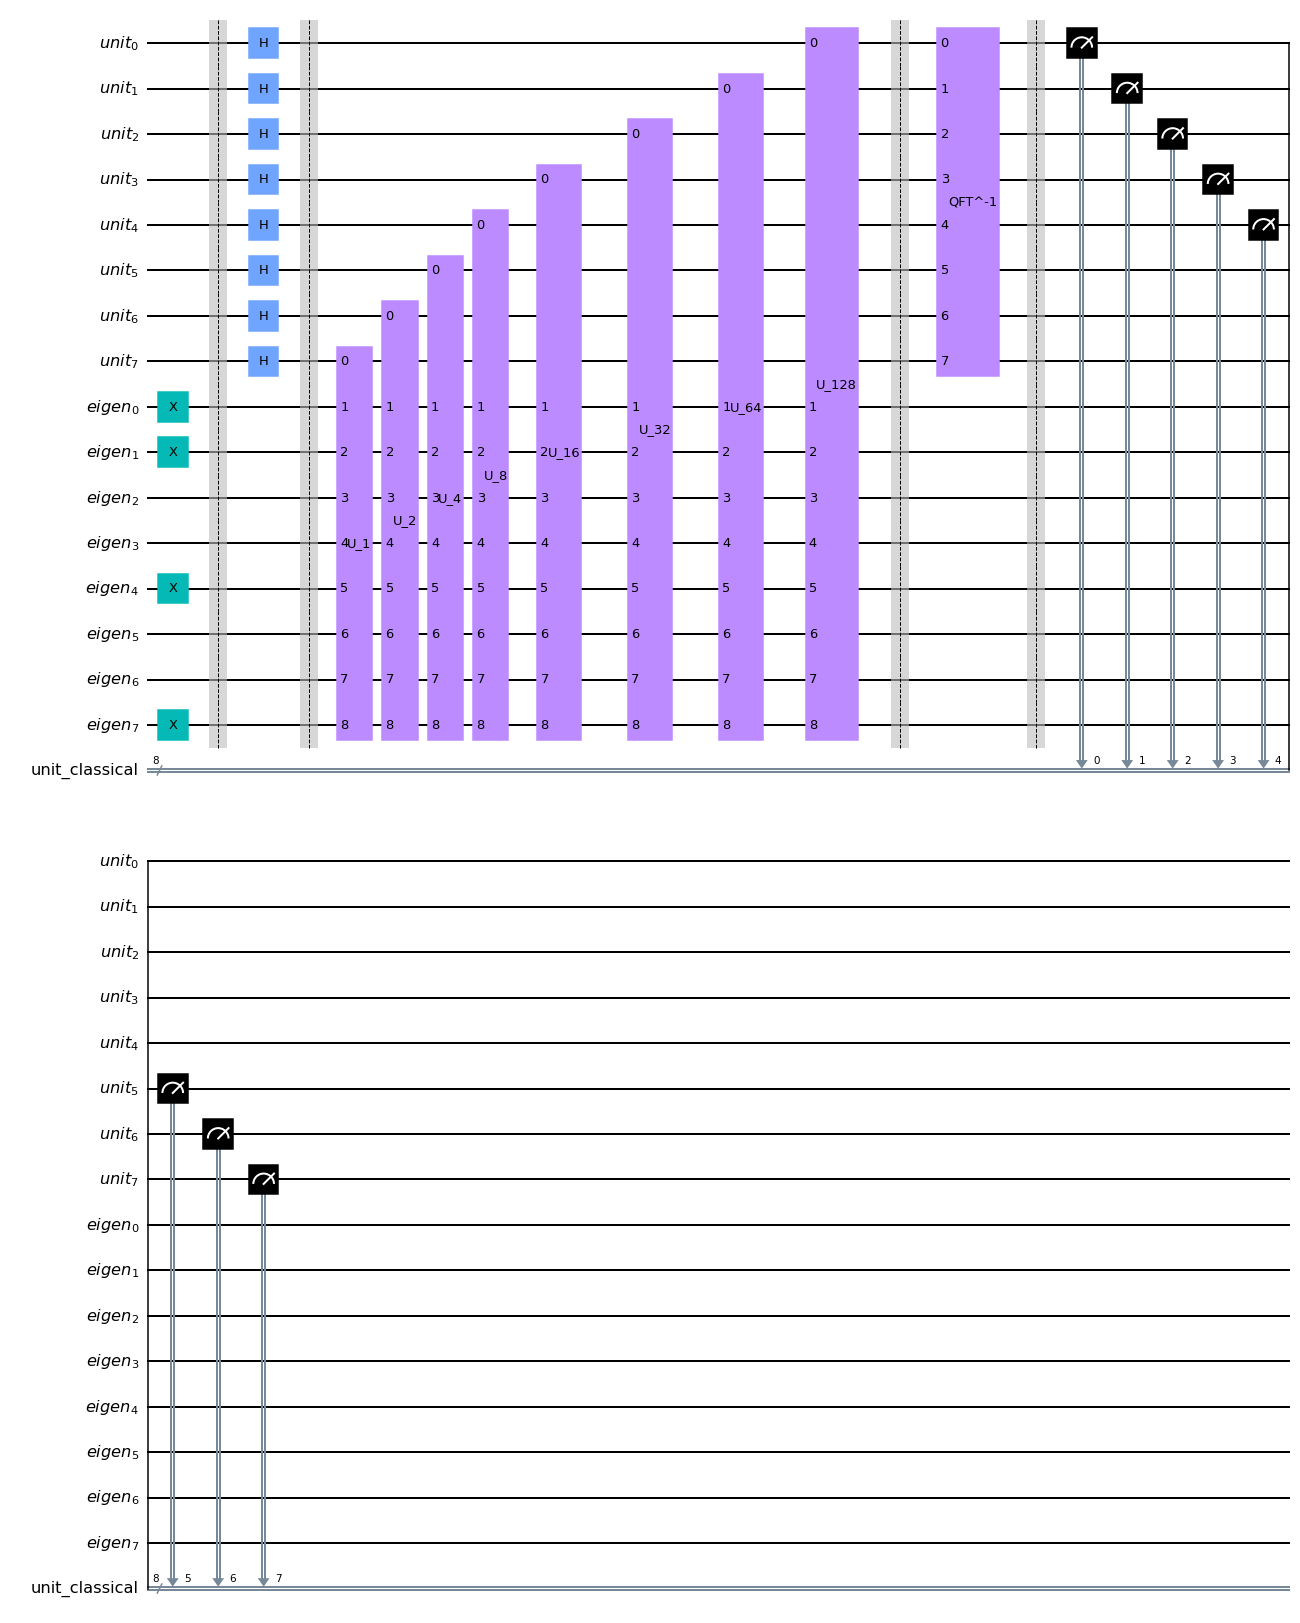

In [9]:
##############INDEX 4##########################
# Creating the 14 qubit circuit, 6 are for the qft and the rest are for the eigenvectors/QPE
unit = QuantumRegister(8, 'unit')
eigen = QuantumRegister(8, 'eigen')
unit_classical = ClassicalRegister(8, 'unit_classical')
qc4 = QuantumCircuit(unit, eigen, unit_classical)
#

# Setting one eigenstate, puts not gates into circuit  
eigenstates(qc4, eigen, 4)
#

# Hadamard on the 'unit' qubits
qc4.h(unit[:])
qc4.barrier()
#

# Controlled Unitary  
for i in range(0, 8):
    qc4.append(final_U(i, eigen, phases), [unit[7-i]] + eigen[:])
#

# Inverse QFT 
qc4.barrier()
qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=True, do_swaps=False, name='QFT^-1')
qc4.append(qft, qc4.qubits[:len(unit)])
qc4.barrier()
#

# Measure
qc4.measure(unit, unit_classical)
#

# Draw
qc4.draw('mpl')


Chosen Eigen value is: 01001011 which is 1-3-4-2


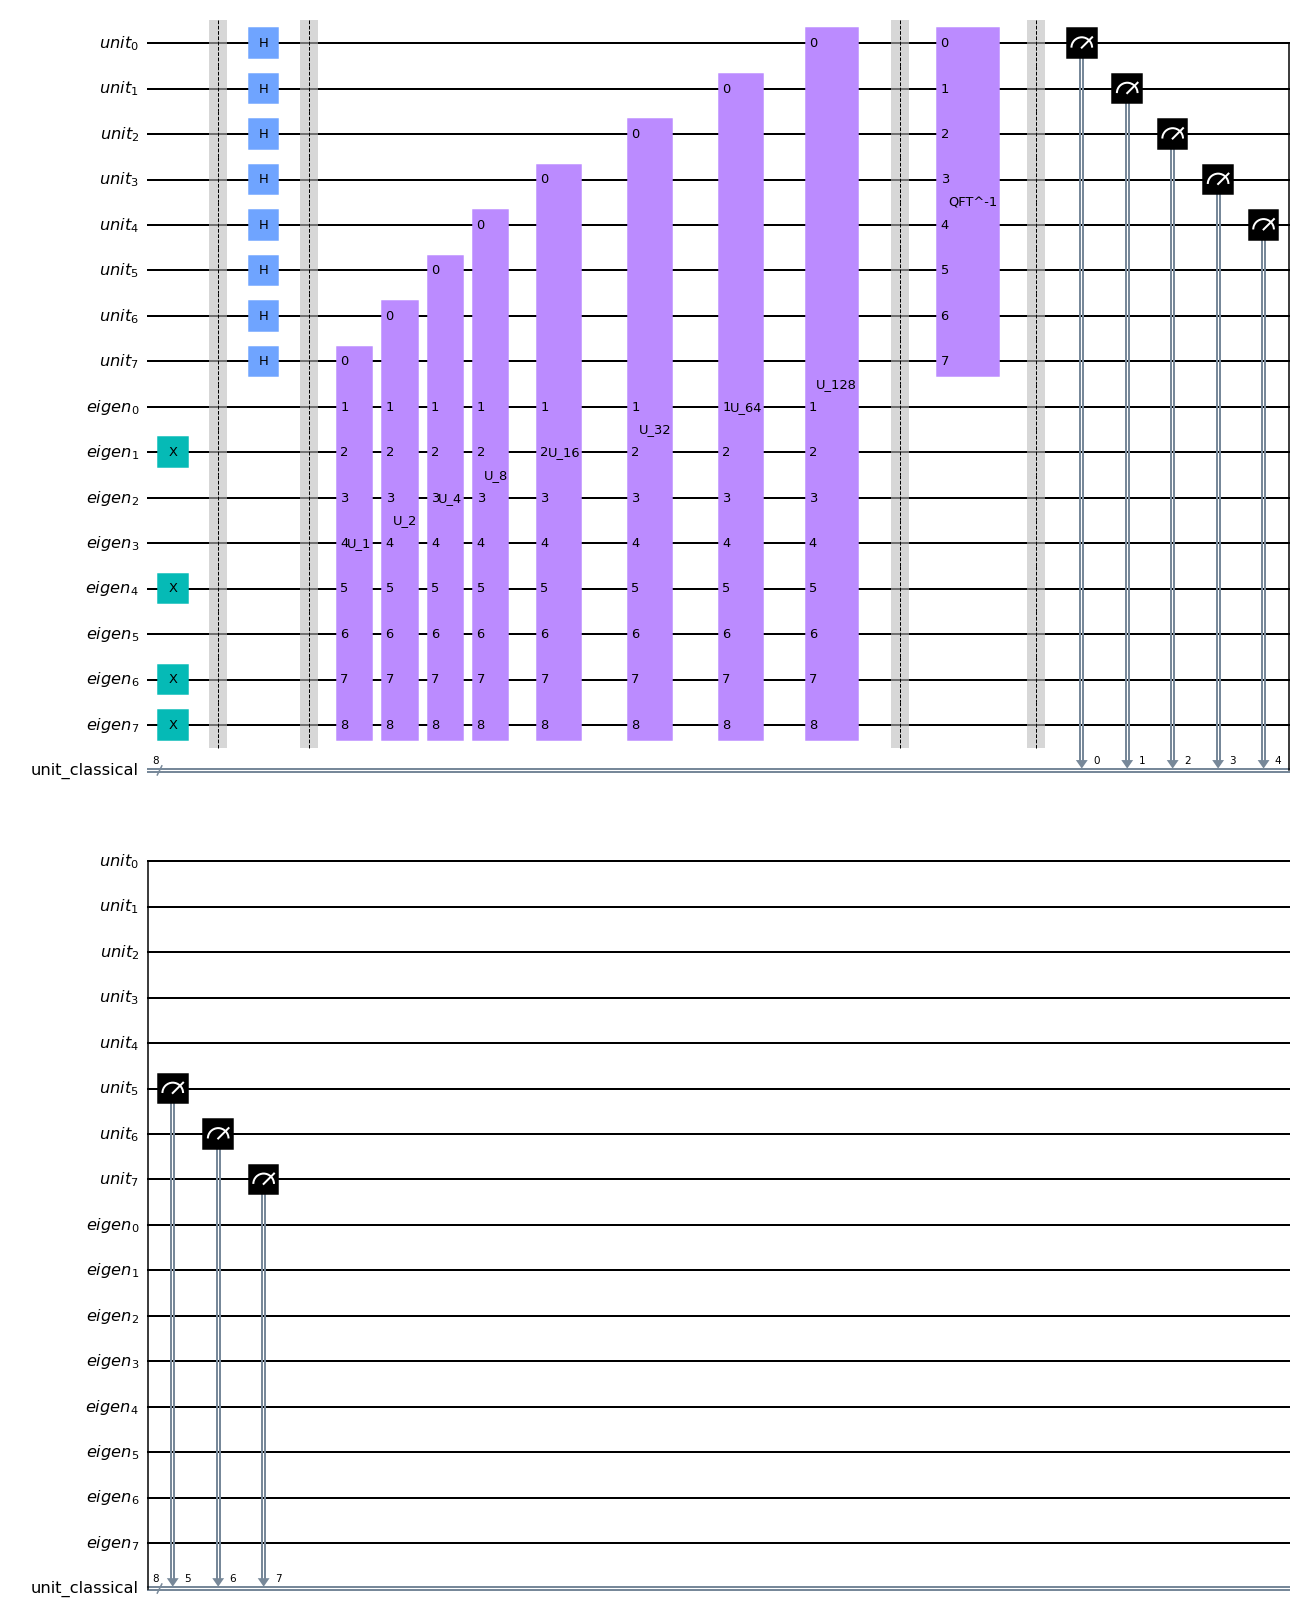

In [10]:
##############INDEX 5##########################
# Creating the 14 qubit circuit, 6 are for the qft and the rest are for the eigenvectors/QPE
unit = QuantumRegister(8, 'unit')
eigen = QuantumRegister(8, 'eigen')
unit_classical = ClassicalRegister(8, 'unit_classical')
qc5 = QuantumCircuit(unit, eigen, unit_classical)
#

# Setting one eigenstate, puts not gates into circuit  
eigenstates(qc5, eigen, 5)
#

# Hadamard on the 'unit' qubits
qc5.h(unit[:])
qc5.barrier()
#

# Controlled Unitary  
for i in range(0, 8):
    qc5.append(final_U(i, eigen, phases), [unit[7-i]] + eigen[:])
#

# Inverse QFT 
qc5.barrier()
qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=True, do_swaps=False, name='QFT^-1')
qc5.append(qft, qc5.qubits[:len(unit)])
qc5.barrier()
#

# Measure
qc5.measure(unit, unit_classical)
#

# Draw
qc5.draw('mpl')


In [11]:
#Running one of the circuits at a time
backend = Aer.get_backend('qasm_simulator')
job = execute(qc5, backend, shots=8192)
count = job.result().get_counts()
print(count)
plot_histogram(count)
print("The most frequent output is:", count.most_frequent(), "which is equal to phi(ij)")

{'101111': 1, '100111': 1, '110001': 1, '001110': 2, '001100': 2, '000101': 1, '011101': 1, '010000': 2, '011001': 2, '011000': 4, '010110': 13, '010010': 6, '110110': 1, '001010': 1, '010111': 4, '001111': 2, '010011': 42, '010100': 8042, '001000': 1, '010001': 5, '010101': 58}
The most frequent output is: 010100 which is equal to phi(ij)


In [11]:
#Running all six at once
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=8192)
job1 = execute(qc1, backend, shots=8192)
job2 = execute(qc2, backend, shots=8192)
job3 = execute(qc3, backend, shots=8192)
job4 = execute(qc4, backend, shots=8192)
job5 = execute(qc5, backend, shots=8192)
count = job.result().get_counts()
count1 = job1.result().get_counts()
count2 = job2.result().get_counts()
count3 = job3.result().get_counts()
count4 = job4.result().get_counts()
count5 = job5.result().get_counts()

print("The most frequent output for", eigen_values[0], "aka", which_eigen(0), "\b, is", count.most_frequent())
print("The most frequent output for", eigen_values[1], "aka", which_eigen(1), "\b, is", count1.most_frequent())
print("The most frequent output for", eigen_values[2], "aka", which_eigen(2), "\b, is", count2.most_frequent())
print("The most frequent output for", eigen_values[3], "aka", which_eigen(3), "\b, is", count3.most_frequent())
print("The most frequent output for", eigen_values[4], "aka", which_eigen(4), "\b, is", count4.most_frequent())
print("The most frequent output for", eigen_values[5], "aka", which_eigen(5), "\b, is", count5.most_frequent())

The most frequent output for 11000110 aka 1-2-3-4 , is 10100001
The most frequent output for 10000111 aka 1-2-4-3 , is 01011011
The most frequent output for 10001101 aka 1-4-2-3 , is 10001100
The most frequent output for 01001110 aka 1-4-3-2 , is 10000000
The most frequent output for 11001001 aka 1-3-2-4 , is 10100001
The most frequent output for 01001011 aka 1-3-4-2 , is 01010000


62cc26e4279108700dfe1916


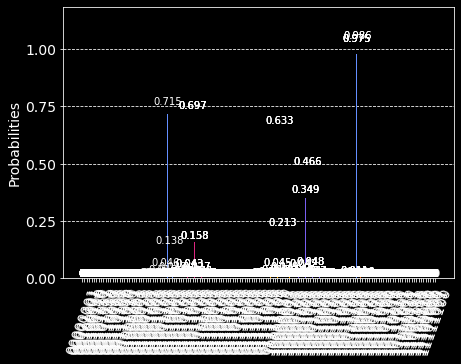

In [13]:
#ALERT, DO NOT RUN THIS CODE BLOCK UNLESS ABSOLUTELY NECESSARY
qc_list = [qc, qc1, qc2, qc3, qc4, qc5]
#On ibmq qasm simulator
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider.backends()
backend = provider.get_backend('ibmq_qasm_simulator')
job = execute(qc_list, backend)
print(job.job_id())
job = backend.retrieve_job(job.job_id()) 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plot_histogram(job.result().get_counts())

In [15]:
print(qc.qasm())

OPENQASM 2.0;
include "qelib1.inc";
gate gate_QFT__1_dg q0,q1,q2,q3,q4,q5,q6,q7 { barrier q0,q1,q2,q3,q4,q5,q6,q7; h q0; barrier q0,q1,q2,q3,q4,q5,q6,q7; cp(-pi/2) q1,q0; h q1; barrier q0,q1,q2,q3,q4,q5,q6,q7; cp(-pi/4) q2,q0; cp(-pi/2) q2,q1; h q2; barrier q0,q1,q2,q3,q4,q5,q6,q7; cp(-pi/8) q3,q0; cp(-pi/4) q3,q1; cp(-pi/2) q3,q2; h q3; barrier q0,q1,q2,q3,q4,q5,q6,q7; cp(-pi/16) q4,q0; cp(-pi/8) q4,q1; cp(-pi/4) q4,q2; cp(-pi/2) q4,q3; h q4; barrier q0,q1,q2,q3,q4,q5,q6,q7; cp(-pi/32) q5,q0; cp(-pi/16) q5,q1; cp(-pi/8) q5,q2; cp(-pi/4) q5,q3; cp(-pi/2) q5,q4; h q5; barrier q0,q1,q2,q3,q4,q5,q6,q7; cp(-pi/64) q6,q0; cp(-pi/32) q6,q1; cp(-pi/16) q6,q2; cp(-pi/8) q6,q3; cp(-pi/4) q6,q4; cp(-pi/2) q6,q5; h q6; barrier q0,q1,q2,q3,q4,q5,q6,q7; cp(-pi/128) q7,q0; cp(-pi/64) q7,q1; cp(-pi/32) q7,q2; cp(-pi/16) q7,q3; cp(-pi/8) q7,q4; cp(-pi/4) q7,q5; cp(-pi/2) q7,q6; h q7; }
gate circuit_1 q0,q1,q2,q3,q4,q5,q6,q7,q8 { cp(0.45261986) q0,q1; p(0) q0; cp(0.98556507) q0,q2; cp(0.066305702) q1,q